In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import geopandas as gpd
import re
import seaborn as sns
import numpy as np
import joypy
import datetime
from bokeh.plotting import figure, output_file, show
%matplotlib inline
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42

In [2]:
routes=pd.read_csv(r"N:\Planning - New File Structure\GIS\Data\GTFS\VRT5_10_18\routes.txt")
routes=pd.DataFrame(routes)
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,route_VRT_2141,VRT,R1,Route 1 Parkcenter,NaN,3,NaN,#ffcd00,000000
1,route_VRT_2142,VRT,R2,Route 2 Broadway,NaN,3,NaN,#685bc7,000000
2,route_VRT_2143,VRT,R3,Route 3 Vista,NaN,3,NaN,#ff8200,000000
3,route_VRT_2144,VRT,R4,Route 4 Roosevelt,NaN,3,NaN,#05c3de,000000
4,route_VRT_2145,VRT,R5,Route 5 Emerald,NaN,3,NaN,#8b0e04,ffffff


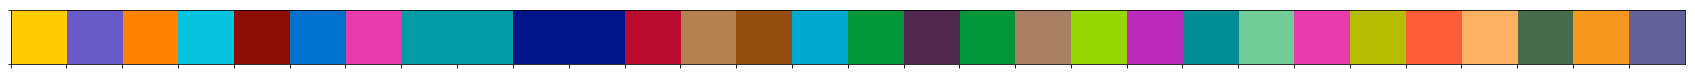

In [3]:
route_colors=sns.color_palette(routes['route_color'])
sns.palplot(route_colors)

In [4]:
OTP_data=pd.read_pickle(r"N:\Planning - New File Structure\Performance\OTP_FY18.pkl")
OTP_data.head()

,MasterRouteName,TripName,StopName,DriverName,TripDate,ScheduledTripStart,ScheduledTripEnd,StopOrder,ScheduledStopTime,ArriveTime,DepartTime
0,Route 10 Hill Road,R10_06:45_Weekday_70582,Gary & Bunch,BRIAN FR BRESHEARS,2018-02-14,2018-02-14 06:45:00,2018-02-14 07:11:00,39,2018-02-14 07:11:00,2018-02-14 07:11:45,2018-02-14 07:11:45
1,Route 10 Hill Road,R10_08:00_Weekday_70587,Gary & Bunch,BRIAN FR BRESHEARS,2018-02-14,2018-02-14 08:00:01,2018-02-14 08:40:00,1,2018-02-14 08:00:01,2018-02-14 08:08:39,2018-02-14 08:09:16
2,Route 10 Hill Road,R10_08:00_Weekday_70587,Tobi & Pierce Park,BRIAN FR BRESHEARS,2018-02-14,2018-02-14 08:00:01,2018-02-14 08:40:00,5,2018-02-14 08:07:00,2018-02-14 08:13:28,2018-02-14 08:14:14
3,Route 10 Hill Road,R10_08:00_Weekday_70587,Hill & Collister,BRIAN FR BRESHEARS,2018-02-14,2018-02-14 08:00:01,2018-02-14 08:40:00,12,2018-02-14 08:14:00,2018-02-14 08:17:22,2018-02-14 08:17:57
4,Route 10 Hill Road,R10_08:00_Weekday_70587,Taft & 28th,BRIAN FR BRESHEARS,2018-02-14,2018-02-14 08:00:01,2018-02-14 08:40:00,23,2018-02-14 08:21:00,2018-02-14 08:25:12,2018-02-14 08:25:45


In [5]:
OTP_data['Relative']=OTP_data['DepartTime']-OTP_data['ScheduledStopTime']

In [6]:
OTP_data=OTP_data.dropna(subset=['DepartTime'])
OTP_data['Invalid']=np.logical_or(np.logical_or(OTP_data['Relative']>datetime.timedelta(hours=2),OTP_data['Relative']<datetime.timedelta(hours=1)),(OTP_data['DepartTime']<OTP_data['ArriveTime']))

In [7]:
OTP_data['Invalid']=np.logical_or(np.logical_or(OTP_data['Relative']>"02:00:00",OTP_data['Relative']<"-01:00:00"),(OTP_data['DepartTime']<OTP_data['ArriveTime']))

In [8]:
OTP_data=OTP_data[OTP_data.Invalid==False]

In [9]:
OTP_data.drop(['Invalid'],axis=1,inplace=True)

In [10]:
OTP_data['Early']=np.where(OTP_data['Relative']<"-00:01:00",True,False)

In [11]:
OTP_data['Late']=np.where(OTP_data['Relative']>"00:05:00",True,False)

In [12]:
OTP_data['OnTime']=np.logical_and(OTP_data['Early']==False,OTP_data['Late']==False)
OTP_data['Terminal']=np.where(np.logical_or(OTP_data['ScheduledTripStart']==OTP_data['ScheduledStopTime'],OTP_data['ScheduledTripEnd']==OTP_data['ScheduledStopTime']),True,False)

In [13]:
OTP_data['date']=OTP_data['ScheduledStopTime'].dt.date
OTP_data['time']=OTP_data['ScheduledStopTime'].dt.time
OTP_data['hour']=[r.hour for r in OTP_data.time]
OTP_data['RelNum']=(pd.to_numeric(OTP_data['Relative'],downcast='integer'))/60000000000
OTP_data=pd.merge(OTP_data,routes,left_on='MasterRouteName',right_on='route_long_name')
OTP_data.sort_values(by='MasterRouteName',inplace=True)

In [14]:
by_route=OTP_data.groupby(['MasterRouteName','hour'])

In [15]:
by_route_early=by_route.Early.sum()
by_route_ontime=by_route.OnTime.sum()
by_route_late=by_route.Late.sum()
by_route_df=pd.DataFrame([by_route_early,by_route_ontime,by_route_late]).T

In [16]:
cols=['Early','OnTime','Late']
by_route_df['Early_pct']=(by_route_df['Early']/by_route_df[cols].sum(axis=1))*100
by_route_df['OnTime_pct']=(by_route_df['OnTime']/by_route_df[cols].sum(axis=1))*100
by_route_df['Late_pct']=(by_route_df['Late']/by_route_df[cols].sum(axis=1))*100

In [17]:
by_route_df.reset_index(inplace=True)

In [18]:
heat=by_route_df.pivot("hour","MasterRouteName","OnTime_pct")
ridge=by_route_df.pivot("MasterRouteName","hour","OnTime_pct")

In [19]:
heat.head()

MasterRouteName,Route 1 Parkcenter,Route 11 Garden City,Route 12 Maple Grove,Route 14 Hyde Park,Route 16 VA Shuttle,Route 17 Warm Springs,Route 18 Harris Ranch,Route 2 Broadway,Route 28 Cole / Victory,Route 29 Overland,...,Route 51 East Nampa,Route 52 Caldwell Blvd,Route 55 CWI Shuttle,Route 6 Orchard,Route 7A Fairview Ustick,Route 7B Fairview - Towne Square Mall,Route 8 Five Mile,Route 8x Five Mile Chinden,Route 9 State Street,Route 9x State Street
hour,,,,,,,,,,,,,,,,,,,,,
5,85.833333,NaN,68.406072,95.180723,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,52.806122,70.430108,NaN,NaN,82.004234,NaN
6,69.923126,NaN,85.513421,79.399468,73.022152,95.619524,82.926829,89.171975,NaN,75.149254,...,60.943396,55.543595,NaN,71.665642,52.285319,75.000000,87.500000,64.609236,79.543358,82.295082
7,51.708801,NaN,58.333333,75.961180,44.444444,75.019889,74.654378,74.789170,60.050891,69.420142,...,65.284178,52.590035,52.789700,47.370471,30.875123,57.692308,50.577664,53.120506,74.711111,79.244424
8,53.320817,NaN,55.853132,73.987854,43.780291,74.577635,76.298701,64.786526,65.336658,69.137189,...,64.273927,38.517745,60.495283,60.586735,25.950413,54.437589,25.965178,22.435021,71.010860,82.091821
9,43.561763,93.345656,61.019164,71.364452,37.991968,76.390008,NaN,76.507686,72.822823,72.721354,...,68.643216,37.232454,57.159763,52.856246,31.211954,56.846673,59.162896,NaN,72.488441,NaN


In [20]:
ridge.head()

hour,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
MasterRouteName,,,,,,,,,,,,,,,,,,
Route 1 Parkcenter,85.833333,69.923126,51.708801,53.320817,43.561763,51.720795,49.975810,43.201543,45.437352,51.172810,46.053602,44.223870,42.256309,52.496038,NaN,NaN,NaN,NaN
Route 11 Garden City,NaN,NaN,NaN,NaN,93.345656,68.076616,76.504065,70.540098,68.637110,68.149325,50.909091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Route 12 Maple Grove,68.406072,85.513421,58.333333,55.853132,61.019164,61.085343,53.762030,50.000000,40.283311,40.254052,21.524064,21.062026,15.563670,42.496357,57.917019,NaN,NaN,NaN
Route 14 Hyde Park,95.180723,79.399468,75.961180,73.987854,71.364452,73.795872,73.165003,78.172293,66.492451,71.519353,69.285999,74.449036,68.024963,70.437956,NaN,NaN,NaN,NaN
Route 16 VA Shuttle,NaN,73.022152,44.444444,43.780291,37.991968,46.794872,46.172249,39.376997,48.392415,42.512077,44.931062,44.313395,45.416316,63.666667,NaN,NaN,NaN,NaN


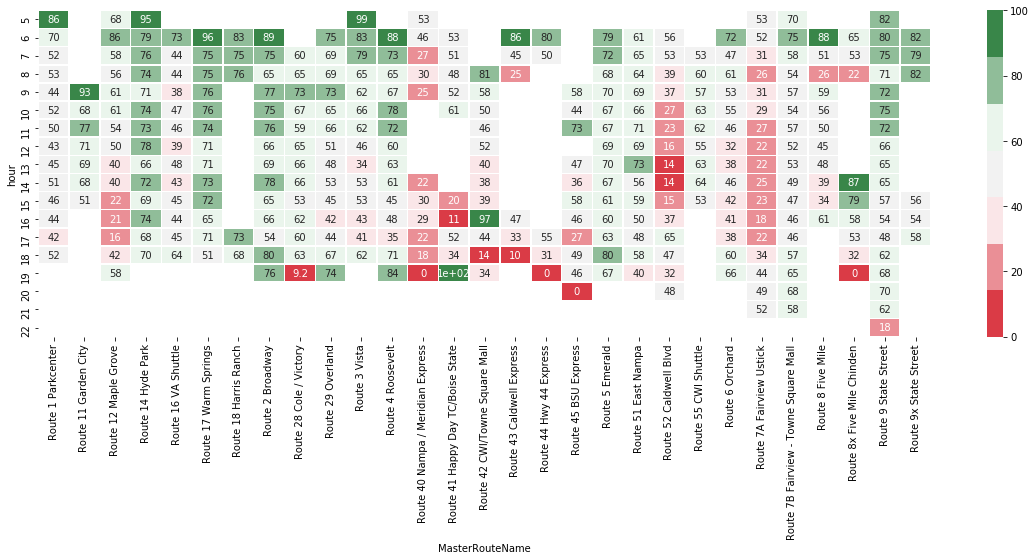

In [21]:
f, ax=plt.subplots(figsize=(20,6))
sns.heatmap(heat, annot=True,linewidths=.5,ax=ax,cmap=sns.diverging_palette(10,133,sep=80,n=7))

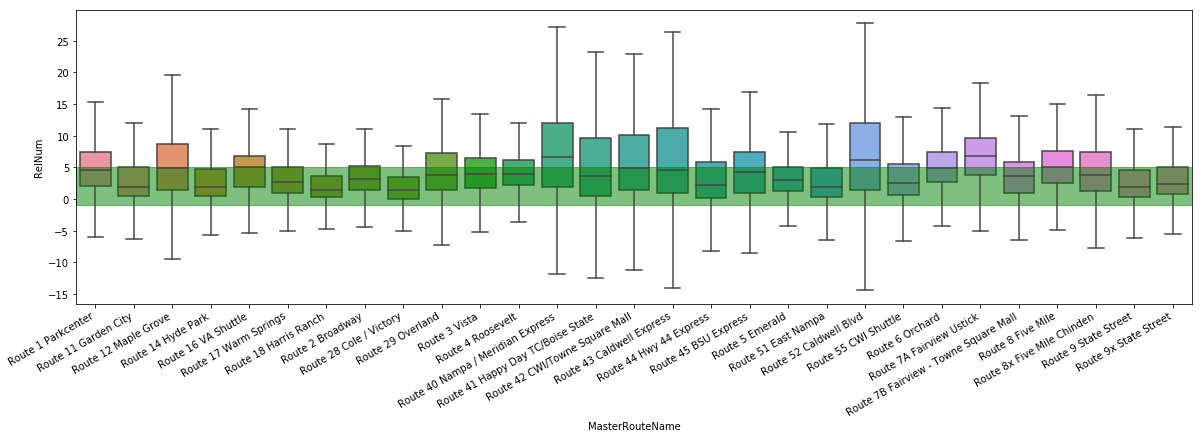

In [22]:
fig, ax=plt.subplots(figsize=(20,6))
sns.boxplot(x=OTP_data.MasterRouteName,y=OTP_data.RelNum,ax=ax,showfliers=False)
plt.yticks(np.arange(-15, 35, step=5))
plt.axhspan(-1,5,color='green',alpha=.5)
fig.autofmt_xdate()

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


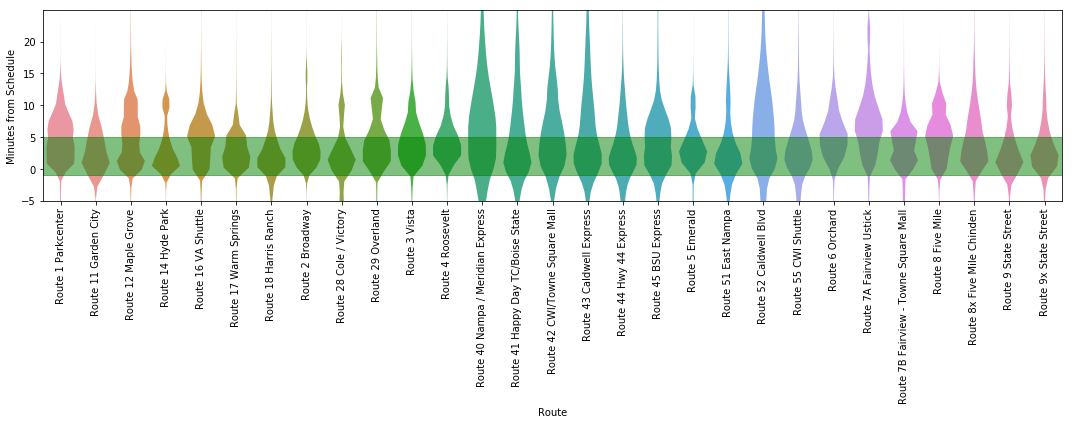

In [23]:
f, ax = plt.subplots(figsize=(15,6))
violin=sns.violinplot(x=OTP_data.MasterRouteName,y=OTP_data.RelNum,ax=ax,scale="width",linewidth=0)
plt.xticks(rotation=90)
plt.yticks(np.arange(-5, 25, step=5))
plt.ylim(-5,25)
plt.ylabel("Minutes from Schedule")
plt.xlabel("Route")
plt.axhspan(-1,5,color='green',alpha=.5)
plt.tight_layout()

In [24]:
OTP_data.set_index("MasterRouteName",inplace=True)
OTP_data.loc['Route 40 Nampa / Meridian Express']

,TripName,StopName,DriverName,TripDate,ScheduledTripStart,ScheduledTripEnd,StopOrder,ScheduledStopTime,ArriveTime,DepartTime,...,RelNum,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
MasterRouteName,,,,,,,,,,,,,,,,,,,,,
Route 40 Nampa / Meridian Express,R40_14:40_Weekday_59236,Main & 8th,Gary McNary,2017-12-04,2017-12-04 14:40:00,2017-12-04 15:47:00,12,2017-12-04 15:36:00,2017-12-04 15:35:09,2017-12-04 15:35:49,...,-0.183333,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_15:55_Weekday_59240,Idaho & 9th,Gary McNary,2017-12-04,2017-12-04 15:55:00,2017-12-04 16:38:00,7,2017-12-04 16:06:00,2017-12-04 16:07:56,2017-12-04 16:09:25,...,3.416667,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_14:40_Weekday_59236,Main & 1st,Gary McNary,2017-12-04,2017-12-04 14:40:00,2017-12-04 15:47:00,14,2017-12-04 15:40:00,2017-12-04 15:37:49,2017-12-04 15:38:23,...,-1.616667,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_14:40_Weekday_59236,University @ BSU Admin Bldg.,Gary McNary,2017-12-04,2017-12-04 14:40:00,2017-12-04 15:47:00,19,2017-12-04 15:47:00,2017-12-04 15:44:42,2017-12-04 15:48:51,...,1.850000,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_15:55_Weekday_59240,Idaho & 1st,Gary McNary,2017-12-04,2017-12-04 15:55:00,2017-12-04 16:38:00,5,2017-12-04 16:02:00,2017-12-04 16:03:16,2017-12-04 16:03:53,...,1.883333,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_14:40_Weekday_59236,Overland @ Black Marlin,Gary McNary,2017-12-04,2017-12-04 14:40:00,2017-12-04 15:47:00,10,2017-12-04 15:14:00,2017-12-04 15:19:46,2017-12-04 15:20:27,...,6.450000,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_16:25_Weekday_59229,Idaho & 9th,Mark Keenan,2017-12-01,2017-12-01 16:25:00,2017-12-01 17:30:00,7,2017-12-01 16:36:00,2017-12-01 16:47:33,2017-12-01 16:50:02,...,14.033333,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_15:55_Weekday_59240,CWI Park & Ride,Gary McNary,2017-12-04,2017-12-04 15:55:00,2017-12-04 16:38:00,13,2017-12-04 16:38:00,2017-12-04 16:42:14,2017-12-04 16:42:14,...,4.233333,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_16:39_Weekday_59239,CWI Park & Ride,Gary McNary,2017-12-04,2017-12-04 16:39:00,2017-12-04 17:23:00,1,2017-12-04 16:39:00,2017-12-04 16:42:14,2017-12-04 16:43:25,...,4.416667,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff


In [25]:
forty=OTP_data.loc['Route 40 Nampa / Meridian Express']
forty=forty.groupby(['StopName','hour'])

In [26]:
forty_early=forty.Early.sum()
forty_ontime=forty.OnTime.sum()
forty_late=forty.Late.sum()
forty_df=pd.DataFrame([forty_early,forty_ontime,forty_late]).T

In [27]:
cols=['Early','OnTime','Late']
forty_df['Early_pct']=(forty_df['Early']/forty_df[cols].sum(axis=1))*100
forty_df['OnTime_pct']=(forty_df['OnTime']/forty_df[cols].sum(axis=1))*100
forty_df['Late_pct']=(forty_df['Late']/forty_df[cols].sum(axis=1))*100

forty_df.reset_index(inplace=True)

heat40=forty_df.pivot("hour","StopName","OnTime_pct")
ridge40=forty_df.pivot("StopName","hour","OnTime_pct")

In [28]:
heat40.head()

StopName,CWI Park & Ride,Happy Day Transit Center,Idaho & 1st,Idaho & 9th,Main & 1st,Main & 8th,Overland @ Black Marlin,University & Joyce,University & Joyce OB,University @ BSU Admin Bldg.
hour,,,,,,,,,,
5,74.576271,41.902314,NaN,NaN,NaN,NaN,54.878049,NaN,NaN,NaN
6,56.786704,51.294118,NaN,NaN,39.959016,50.819672,44.672131,22.222222,NaN,29.816514
7,46.779661,NaN,38.492872,38.775510,22.379032,17.444219,26.747312,29.327902,0.0,7.186858
8,26.966292,32.900433,25.200000,31.726908,0.000000,NaN,41.818182,31.629393,0.0,4.471545
9,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


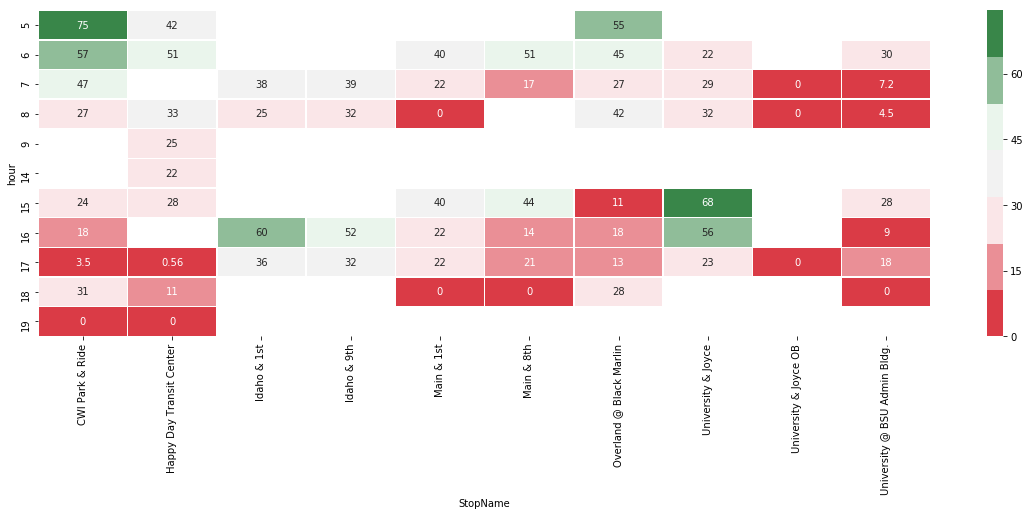

In [29]:
f, ax=plt.subplots(figsize=(20,6))
sns.heatmap(heat40, annot=True,linewidths=.5,ax=ax,cmap=sns.diverging_palette(10,133,sep=80,n=7))

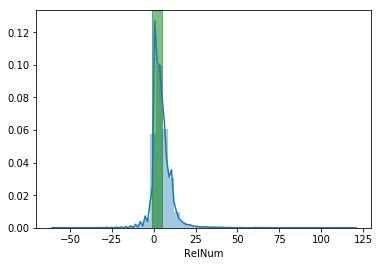

In [30]:
sns.distplot(OTP_data['RelNum'])
plt.axvspan(-1,5,color='green',alpha=.5)

In [31]:
OTP_data.RelNum.describe()

count    740601.000000
mean          4.607455
std           6.521486
min         -60.000000
25%           1.216667
50%           3.600000
75%           6.783333
max         119.883333
Name: RelNum, dtype: float64

In [32]:
forty.head()

,TripName,StopName,DriverName,TripDate,ScheduledTripStart,ScheduledTripEnd,StopOrder,ScheduledStopTime,ArriveTime,DepartTime,...,RelNum,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
MasterRouteName,,,,,,,,,,,,,,,,,,,,,
Route 40 Nampa / Meridian Express,R40_14:40_Weekday_59236,Main & 8th,Gary McNary,2017-12-04,2017-12-04 14:40:00,2017-12-04 15:47:00,12,2017-12-04 15:36:00,2017-12-04 15:35:09,2017-12-04 15:35:49,...,-0.183333,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_15:55_Weekday_59240,Idaho & 9th,Gary McNary,2017-12-04,2017-12-04 15:55:00,2017-12-04 16:38:00,7,2017-12-04 16:06:00,2017-12-04 16:07:56,2017-12-04 16:09:25,...,3.416667,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_14:40_Weekday_59236,Main & 1st,Gary McNary,2017-12-04,2017-12-04 14:40:00,2017-12-04 15:47:00,14,2017-12-04 15:40:00,2017-12-04 15:37:49,2017-12-04 15:38:23,...,-1.616667,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_14:40_Weekday_59236,University @ BSU Admin Bldg.,Gary McNary,2017-12-04,2017-12-04 14:40:00,2017-12-04 15:47:00,19,2017-12-04 15:47:00,2017-12-04 15:44:42,2017-12-04 15:48:51,...,1.850000,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_15:55_Weekday_59240,Idaho & 1st,Gary McNary,2017-12-04,2017-12-04 15:55:00,2017-12-04 16:38:00,5,2017-12-04 16:02:00,2017-12-04 16:03:16,2017-12-04 16:03:53,...,1.883333,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_14:40_Weekday_59236,Overland @ Black Marlin,Gary McNary,2017-12-04,2017-12-04 14:40:00,2017-12-04 15:47:00,10,2017-12-04 15:14:00,2017-12-04 15:19:46,2017-12-04 15:20:27,...,6.450000,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_16:25_Weekday_59229,Idaho & 9th,Mark Keenan,2017-12-01,2017-12-01 16:25:00,2017-12-01 17:30:00,7,2017-12-01 16:36:00,2017-12-01 16:47:33,2017-12-01 16:50:02,...,14.033333,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_15:55_Weekday_59240,CWI Park & Ride,Gary McNary,2017-12-04,2017-12-04 15:55:00,2017-12-04 16:38:00,13,2017-12-04 16:38:00,2017-12-04 16:42:14,2017-12-04 16:42:14,...,4.233333,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff
Route 40 Nampa / Meridian Express,R40_16:39_Weekday_59239,CWI Park & Ride,Gary McNary,2017-12-04,2017-12-04 16:39:00,2017-12-04 17:23:00,1,2017-12-04 16:39:00,2017-12-04 16:42:14,2017-12-04 16:43:25,...,4.416667,route_VRT_2159,VRT,R40,Route 40 Nampa / Meridian Express,NaN,3,NaN,#aa8066,ffffff


In [33]:
violin.figure.savefig(r"N:\Planning - New File Structure\Performance\Annual Report\VRT_ontime_violin.pdf",transparent=True)